In [1]:
import sys
sys.path.append("..")

import torch
import torch.optim as optim

import matplotlib.pyplot as plt

from datasets import *
from ad import *

torch.manual_seed(1234)

/home/antonxue/lib/miniconda3/envs/arpro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_printoptions(precision=3, linewidth=120)

In [16]:
cat = "transistor"
model = FastflowAdModel()
state_dict = torch.load(f"../_dump/ad_fast_mvtec_{cat}_best.pt")["model_state_dict"]
model.load_state_dict(state_dict)
model.eval();

In [17]:
torch.manual_seed(1234)
N = 8
dataloader = get_ad_dataloader("mvtec", batch_size=N, category=cat, split="test", normalize_image=False)
for batch in dataloader:
    x = batch["image"]
    out = model(2*x - 1)
    break

thresh = out.alpha.flatten(1).quantile(0.95, dim=1)
alpha_thresh = (out.alpha.detach() > thresh.view(N,1,1,1)).long()
print(batch["label"])
print(out.score)

tensor([1, 0, 0, 1, 0, 0, 0, 1])
tensor([1287.644,   -5.471,   59.137,  370.654,    3.129,   20.503,   44.791, 1782.489], grad_fn=<AddBackward0>)


<Figure size 640x480 with 0 Axes>

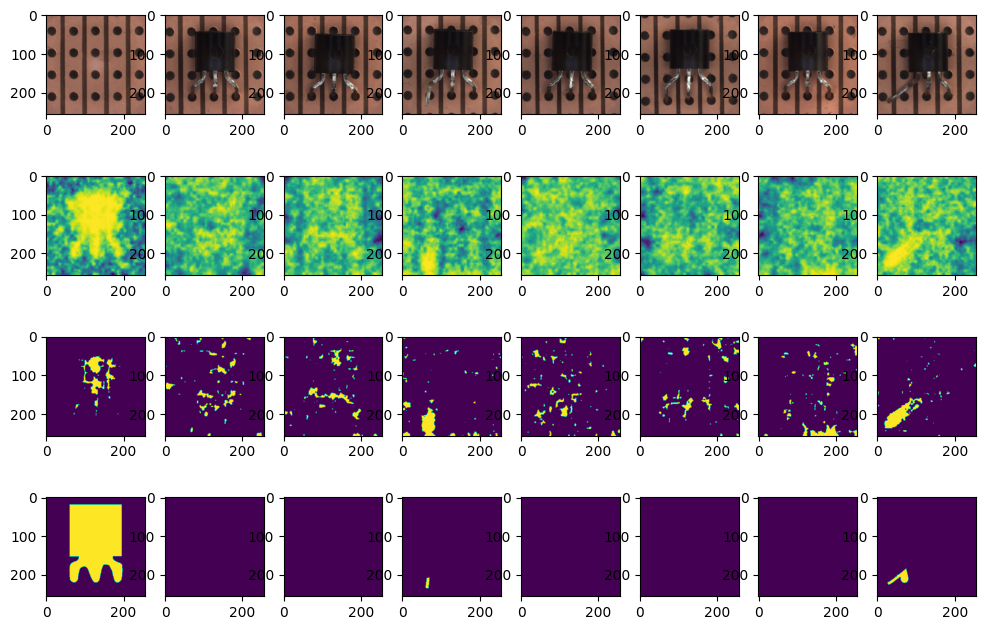

In [18]:
plt.clf()
fig, ax = plt.subplots(4,8, figsize=(12, 8))
for i in range(8):
    xi = x[i].detach()
    alphai = out.alpha[i].detach()
    alphai_thresh = alpha_thresh[i]
    maski = batch["mask"][i]
    ax[0,i].imshow(xi.numpy().transpose(1,2,0))
    ax[1,i].imshow(alphai.numpy().transpose(1,2,0))
    ax[2,i].imshow(alphai_thresh.numpy().transpose(1,2,0))
    ax[3,i].imshow(maski.numpy().transpose(1,2,0))

In [6]:
alphai_thresh.shape

torch.Size([1, 256, 256])

In [7]:
# model = VaeADModel()
cat = "bottle"
model = EfficientAdADModel(model_size="medium")
state_dict = torch.load(f"../_dump/ad_eff_mvtec_{cat}_last.pt")["model_state_dict"]

# state_dict = torch.load   ("../_dump/ad_vae_mvtec_transistor_rs1.00_ks2.00_cs0.1_best.pt")["model_state_dict"]
model.load_state_dict(state_dict)
model.eval()
;

''

In [8]:
torch.manual_seed(1235)
dataloader = get_ad_dataloader("mvtec", batch_size=8, category=cat, split="test", normalize_image=False)
for batch in dataloader:
    break

In [9]:
batch["label"]

tensor([1, 0, 1, 1, 1, 1, 1, 0])

In [10]:
batch.keys()

dict_keys(['image', 'mask', 'label'])

In [11]:
with torch.no_grad():
    x = batch["image"]
    out = model(2*x-1)

In [12]:
score = out.score
thresh = out.alpha.flatten(1).quantile(0.95, dim=1)
batch["label"], score, thresh

(tensor([1, 0, 1, 1, 1, 1, 1, 0]),
 tensor([ 5.925, 11.428,  5.805, 23.535,  6.623,  6.433, 11.055, 10.193]),
 tensor([ 3.100,  3.371,  2.715, 14.962,  2.784,  3.331,  3.498,  2.974]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

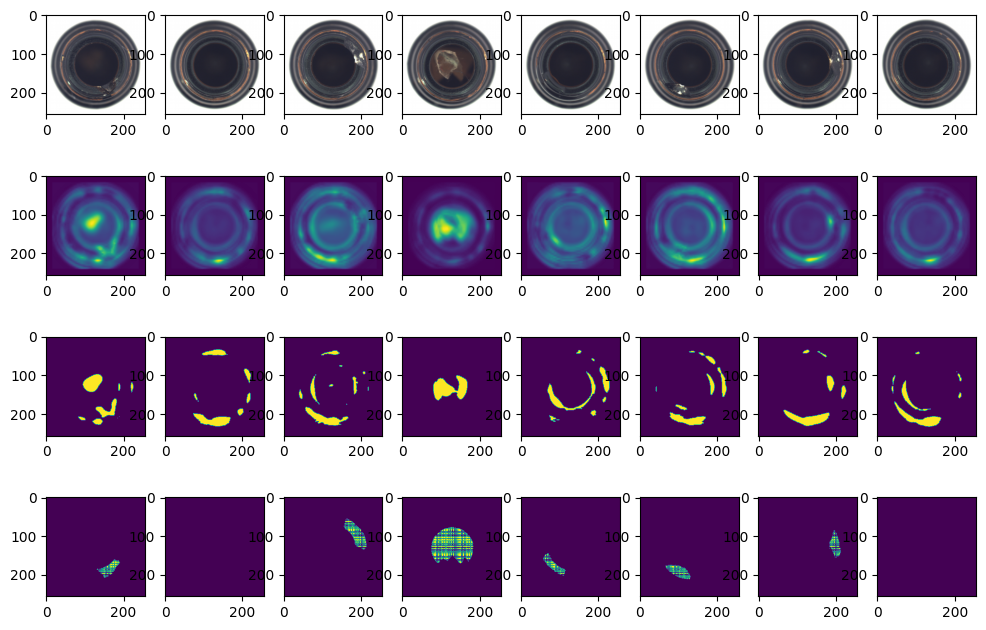

In [13]:
plt.clf()

fig, ax = plt.subplots(4,8, figsize=(12, 8))
for i in range(8):
    xi = x[i].detach()
    xhati = (out.others["map_ae"][i].detach()*0.5 + 0.5).clamp(0,1)
    alphai = out.alpha[i].max(dim=0).values.detach()
    alphai_big = alphai > thresh[i]
    ax[0,i].imshow(xi.numpy().transpose(1,2,0))
    ax[1,i].imshow(alphai.cpu().numpy())
    ax[2,i].imshow(alphai_big.cpu().numpy())
    ax[3,i].imshow(batch["mask"][i].numpy().transpose(1,2,0))
    